In [105]:
import sys
import shutil
import time
import resource
import json
from pathlib import Path

from scipy.stats import multivariate_normal, norm

import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping, Callback
#from keras.metrics import AUC, RootMeanSquaredError
from tensorflow.keras.models import Model

import numpy as np
import pandas as pd
from sklearn.utils import class_weight
from sklearn.metrics import (r2_score, auc, roc_curve, roc_auc_score, 
                            log_loss, fbeta_score,precision_recall_curve,
                             mean_absolute_error
                            )

import nn_models as nnm
import dataprocessing as dp
import visualization as viz

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns

# Try Normalization Layer

In [1]:
class HyperLSTMAutoEncoder(kt.HyperModel):
    def __init__(self, timesteps):
        super(HyperLSTMAutoEncoder, self).__init__()
        
    def build(self, hp):
        
        hp_units = hp.Int('outer-layer', min_value=28, max_value=64, step=4)
        model = tf.keras.Sequential([
            # Encoder
            tf.keras.layers.LSTM(hp_units, return_sequences = False),
            # Code layer
            tf.keras.layers.RepeatVector(self.timesteps),
            # Decoder
            tf.keras.layers.LSTM(hp_units, return_sequences = True),
            # TimeDistributed layer
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.timesteps))
            
        ])
        
        # Tune the learning rate
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-6, 1e-3])
        
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                            loss='mean_squared_error')
        
        return model

NameError: name 'kt' is not defined

In [249]:
class FunctionalDeepLSTMAutoEncoder(Model):
    def __init__(self, timesteps, input_dim, code_dim, lstm_dim, num_layers):
        super(FunctionalDeepLSTMAutoEncoder, self).__init__()
        self.timesteps  = timesteps
        self.input_dim  = input_dim
        self.code_dim   = code_dim
        self.lstm_dim   = lstm_dim
        self.num_layers = num_layers

#         self.encoder = tf.keras.Sequential()
#         self.encoder.add(tf.keras.Input(shape=(self.timesteps, self.input_dim)))

#         for i in range(1, self.num_layers):
#             self.encoder.add(tf.keras.layers.LSTM(int(self.lstm_dim/i), return_sequences = True))

#         self.encoder.add(tf.keras.layers.LSTM(self.code_dim, return_sequences = False, name = 'encoder'))

#         self.decoder = tf.keras.Sequential()
#         self.decoder.add(tf.keras.layers.RepeatVector(self.timesteps))

#         for i in range(1, self.num_layers):
#             self.decoder.add(tf.keras.layers.LSTM(int(self.lstm_dim/i), return_sequences = True))

#         self.decoder.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.input_dim)))

        self.lstm1 = tf.keras.layers.LSTM(64, return_sequences = False)
        self.lstm2 = tf.keras.layers.LSTM(32, return_sequences = True)
#         self.lstm3 = tf.keras.layers.LSTM(32, return_sequences = False)
        #self.lstm4 = tf.keras.layers.LSTM(24, return_sequences = False)
        
        self.code_layer = tf.keras.layers.RepeatVector(self.timesteps)
        
        self.decoder1 = tf.keras.layers.LSTM(32, return_sequences = True)
        self.decoder2 = tf.keras.layers.LSTM(64, return_sequences = True)
#         self.decoder3 = tf.keras.layers.LSTM(64, return_sequences = True)
        #self.decoder4 = tf.keras.layers.LSTM(128, return_sequences = True)
        
        self.td_layer = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.input_dim))
        
    def call(self, x):
        
        x = self.lstm1(x)
        x = self.lstm2(x)
#         x = self.lstm3(x)
        #x = self.lstm4(x)
        x = self.code_layer(x)
        x = self.decoder1(x)
        x = self.decoder2(x)
#         x = self.decoder3(x)
        #x = self.decoder4(x)
        x = self.td_layer(x)
        
        return x
    
    def build_graph(self):
        x = tf.keras.layers.Input(shape=(self.timesteps, self.input_dim),)
        return Model(inputs=[x], outputs=self.call(x))

In [250]:
# class FunctionalLSTMAutoEncoder(Model):
#     def __init__(self, timesteps, input_dim, lstm_dim, batch_size):
#         super(FunctionalLSTMAutoEncoder, self).__init__()
#         self.timesteps = timesteps
#         self.input_dim = input_dim
#         self.lstm_dim  = lstm_dim
        
#         #self.input_layer = tf.keras.Input(shape=(self.timesteps, self.input_dim))
#         self.lstm1 = tf.keras.layers.LSTM(self.lstm_dim, input_shape=(self.timesteps, self.input_dim),
#                                           return_sequences=False)
#         self.code_layer = tf.keras.layers.RepeatVector(self.timesteps)
#         self.lstm2 = tf.keras.layers.LSTM(self.lstm_dim, return_sequences=True)
#         self.td_layer = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.input_dim))
        
#     def call(self, x):
        
#         #x = self.input_layer(x)
#         x = self.lstm1(x)
#         x = self.code_layer(x)
#         x = self.lstm2(x)
#         x = self.td_layer(x)
#         return x
    
#     def build_graph(self):
#         x = tf.keras.layers.Input(shape=(self.timesteps, self.input_dim),)
#         return Model(inputs=[x], outputs=self.call(x))

In [251]:
# class LSTMAutoEncoder(Model):
#     def __init__(self, timesteps, input_dim, lstm_dim, batch_size):
#         super(LSTMAutoEncoder, self).__init__()
#         self.timesteps = timesteps
#         self.input_dim = input_dim
#         self.lstm_dim  = lstm_dim
#         self.batch_size = batch_size

#         self.encoder = tf.keras.models.Sequential()
#         self.encoder.add(tf.keras.Input(shape=(self.timesteps, self.input_dim), ))
#                                        #batch_input_shape=(self.batch_size, self.timesteps, self.input_dim),))
#         #self.encoder.add(tf.keras.layers.Normalization(axis = [0,-1]))
#         #self.encoder.add(tf.keras.layers.LSTM(self.lstm_dim*2, activation='relu', return_sequences=True))
#         self.encoder.add(tf.keras.layers.LSTM(self.lstm_dim, 
#                                               #kernel_regularizer=tf.keras.regularizers.L2(),
#                                               kernel_initializer='random_uniform',
#                                               #bias_regularizer=tf.keras.regularizers.L2(1e-4),
#                                               bias_initializer = 'random_normal',
#                                               #stateful=True,
#                                               return_sequences=False, 
#                                               name = "encoder"))

#         self.decoder = tf.keras.models.Sequential()
#         self.decoder.add(tf.keras.layers.RepeatVector(self.timesteps))
#         self.decoder.add(tf.keras.layers.LSTM(self.input_dim, 
#                                               #kernel_regularizer=tf.keras.regularizers.L2(),
#                                               kernel_initializer='random_uniform',
#                                               #bias_regularizer=tf.keras.regularizers.L2(1e-4),
#                                               bias_initializer = 'random_normal',
#                                               #stateful=True,
#                                          return_sequences=True, name = 'decoder'))
#         #self.decoder.add(tf.keras.layers.LSTM(self.lstm_dim*2, activation='relu', return_sequences=True))
        
#         self.decoder.add(tf.keras.layers.TimeDistributed(
#                                 tf.keras.layers.Dense(self.input_dim)
#         ))

#     def call(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
#         return decoded
    
#     # AFAIK: The most convenient method to print model.summary() 
#     # similar to the sequential or functional API like.
#     def build_graph(self):
#         x = tf.keras.layers.Input(shape=(self.timesteps, self.input_dim),)
#         return Model(inputs=[x], outputs=self.call(x))

In [252]:
### Load the data - individual
# data, target = dp.create_featured_dataset('3-jk', sensor='both', dlh=0, 
#                                           keep_SH=False, keep_event=True, smote=None)

In [253]:
### Load the data - general
data, target, holdout_data, holdout_target = \
    dp.load_general_data_lstm('3-jk', sensor='both', dlh=0, keep_SH=False, keep_event=True, smote=None)

['1-sf', '10-rc', '12-mb', '17-sb', '19-me', '2-bd', '22-ap', '26-tc', '31-ns', '32-rf', '36-af', '38-cs', '39-dg', '4-rs', '41-pk', '43-cm', '7-sb']
The beginning shape is:  (9902, 99)
After dropping rows with NaN in the SH_Event columns, the shape is:  (8112, 99)
NaN values in this dataset:  False
The left data frame set shape is:  (8112, 48)
The right data frame set shape is:  (8112, 48)
The keep left data frame set shape is:  (8112, 24)
The keep right data frame set shape is:  (8112, 24)
Not adding fake positive data samples.
Index(['t25_l', 't26_l', 't27_l', 't28_l', 't29_l', 't30_l', 't31_l', 't32_l',
       't33_l', 't34_l', 't35_l', 't36_l', 't37_l', 't38_l', 't39_l', 't40_l',
       't41_l', 't42_l', 't43_l', 't44_l', 't45_l', 't46_l', 't47_l', 't48_l'],
      dtype='object')
Index(['t25_r', 't26_r', 't27_r', 't28_r', 't29_r', 't30_r', 't31_r', 't32_r',
       't33_r', 't34_r', 't35_r', 't36_r', 't37_r', 't38_r', 't39_r', 't40_r',
       't41_r', 't42_r', 't43_r', 't44_r', 't4

The keep left data frame set shape is:  (6855, 24)
The keep right data frame set shape is:  (6855, 24)
Not adding fake positive data samples.
Index(['t25_l', 't26_l', 't27_l', 't28_l', 't29_l', 't30_l', 't31_l', 't32_l',
       't33_l', 't34_l', 't35_l', 't36_l', 't37_l', 't38_l', 't39_l', 't40_l',
       't41_l', 't42_l', 't43_l', 't44_l', 't45_l', 't46_l', 't47_l', 't48_l'],
      dtype='object')
Index(['t25_r', 't26_r', 't27_r', 't28_r', 't29_r', 't30_r', 't31_r', 't32_r',
       't33_r', 't34_r', 't35_r', 't36_r', 't37_r', 't38_r', 't39_r', 't40_r',
       't41_r', 't42_r', 't43_r', 't44_r', 't45_r', 't46_r', 't47_r', 't48_r'],
      dtype='object')
The size of the dataset for 41-pk is (6855, 24, 2)
The size of the target for 41-pk is (6855,)
The beginning shape is:  (6236, 99)
After dropping rows with NaN in the SH_Event columns, the shape is:  (2804, 99)
NaN values in this dataset:  False
The left data frame set shape is:  (2804, 48)
The right data frame set shape is:  (2804, 48)

In [254]:
### Split the data into train, val, and testing
target = np.where(target == 1, 1, 0)

train_idx, val_idx, test_idx = dp.split_data_cv_indx(data,target)

# Prepare data for the autoencoder model
normal, anomalous = dp.process_autoencoder(data[train_idx], data[test_idx], data[val_idx],
                                           target[train_idx], target[test_idx], target[val_idx])

normal_train, normal_val, normal_train_target, normal_val_target             = normal
anomalous_train, anomalous_val, anomalous_train_target, anomalous_val_target = anomalous

Train labels shape:  (47596,)
Test labels shape:  (13804,)
Val labels shape:  (26726,)
Normal train data shape is:  (47467, 24, 2)
Normal test data shape is:  (13761, 24, 2)
Normal val data shape is:  (26683, 24, 2)
Anomalous train data shape is:  (129, 24, 2)
Anomalous test data shape is:  (43, 24, 2)
Anomalous val data shape is:  (43, 24, 2)


In [255]:
train_data = np.vstack([normal_train, normal_val])
y_train    = np.hstack([normal_train_target, normal_val_target])

In [256]:
train_data.shape

(74150, 24, 2)

In [257]:
y_train.shape

(74150,)

In [258]:
# Try Normalizing the data
#scaled_normal_train, scaled_test, scaled_normal_val = dp.normalize_data(normal_train, data[test_idx], normal_val)

train_data = normal_train # scaled_normal_train #
y_train    = normal_train_target

test_data  = data[test_idx] #scaled_test #
y_test     = target[test_idx]

val_data   = normal_val #scaled_normal_val #
y_val      = normal_val_target

print("Anomalous train data shape is: ", anomalous_train.shape)
print("Anomalous val data shape is: ", anomalous_val.shape)

Anomalous train data shape is:  (129, 24, 2)
Anomalous val data shape is:  (43, 24, 2)


In [259]:
# train_data[:5]

In [260]:
# np.gcd.reduce([train_data.shape[0], test_data.shape[0], val_data.shape[0], anomalous_train.shape[0]])

In [261]:
# A = np.array([[[1,2,3], [4,5,6]], [[0,0,0], [1,1,1]]])
# test_layer = tf.keras.layers.Normalization(axis=-1)
# #test_layer.adapt(A)
# test_layer(A)

In [262]:
# train_weights = {0: 1, 1: 1}
# print("No train weights assigned for autoencoder")

In [263]:
# Reshape the datasets
# train_data = np.reshape(train_data, (train_data.shape[0], train_data.shape[2], train_data.shape[1]))
# test_data  = np.reshape(test_data, (test_data.shape[0], test_data.shape[2], test_data.shape[1]))
# val_data   = np.reshape(val_data, (val_data.shape[0], val_data.shape[2], val_data.shape[1]))

In [264]:
### Test running the model
loss = 'mean_squared_error'
TIME_STEPS = 24
BATCH_SIZE = 128
num_features = 2

lstm_dim = 64
code_dim = 32

### Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=5,
                                                    mode='min')



#model = nnm.HyperLSTMAutoEncoder(loss=loss, time_steps=TIME_STEPS, num_features=num_features)

In [265]:
# Test single model

autoencoder = FunctionalDeepLSTMAutoEncoder(TIME_STEPS, num_features, code_dim, lstm_dim, 2) #BATCH_SIZE) #, timesteps) #nnm.AnomalyDetector(data.shape[1])
# autoencoder = FunctionalLSTMAutoEncoder(TIME_STEPS, num_features, 16, BATCH_SIZE)

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                    loss='mean_squared_error')
                    #metrics=[tf.keras.metrics.Precision(name='precision'),
                    #                tf.keras.metrics.Recall(name='recall'),
                    #                tf.keras.metrics.AUC(name='auc'),
                    #                tf.keras.metrics.AUC(name='prc', curve='PR')])

history = autoencoder.fit(train_data, train_data,
          epochs=1000, #callbacks = [early_stopping],
          validation_split=0.2, batch_size=BATCH_SIZE)
          #validation_data=(val_data, val_data))

Epoch 1/1000
297/297 [==============================] - 12s 29ms/step - loss: 22613.6934 - val_loss: 29749.1191
Epoch 2/1000
297/297 [==============================] - 8s 26ms/step - loss: 22587.7754 - val_loss: 29720.5742
Epoch 3/1000
297/297 [==============================] - 7s 24ms/step - loss: 22559.2305 - val_loss: 29688.0996
Epoch 4/1000
297/297 [==============================] - 6s 21ms/step - loss: 22526.3262 - val_loss: 29651.4238
Epoch 5/1000
297/297 [==============================] - 7s 22ms/step - loss: 22490.4395 - val_loss: 29610.3516
Epoch 6/1000
297/297 [==============================] - 6s 21ms/step - loss: 22450.9805 - val_loss: 29563.5410
Epoch 7/1000
297/297 [==============================] - 6s 21ms/step - loss: 22408.4844 - val_loss: 29511.5977
Epoch 8/1000
297/297 [==============================] - 6s 21ms/step - loss: 22356.2520 - val_loss: 29440.7793
Epoch 9/1000
297/297 [==============================] - 6s 21ms/step - loss: 22287.6348 - val_loss: 29377.6680


Epoch 147/1000
297/297 [==============================] - 10s 32ms/step - loss: 20102.2246 - val_loss: 27005.4492
Epoch 148/1000
297/297 [==============================] - 8s 25ms/step - loss: 20089.2227 - val_loss: 26991.1992
Epoch 149/1000
297/297 [==============================] - 8s 26ms/step - loss: 20076.2422 - val_loss: 26976.9668
Epoch 150/1000
297/297 [==============================] - 7s 25ms/step - loss: 20063.2656 - val_loss: 26962.7363
Epoch 151/1000
297/297 [==============================] - 8s 25ms/step - loss: 20050.2949 - val_loss: 26948.5137
Epoch 152/1000
297/297 [==============================] - 7s 24ms/step - loss: 20037.3301 - val_loss: 26934.2930
Epoch 153/1000
297/297 [==============================] - 7s 25ms/step - loss: 20024.3789 - val_loss: 26920.0840
Epoch 154/1000
297/297 [==============================] - 8s 25ms/step - loss: 20011.4238 - val_loss: 26905.8828
Epoch 155/1000
297/297 [==============================] - 8s 26ms/step - loss: 19998.4824 - val

297/297 [==============================] - 6s 22ms/step - loss: 18286.6816 - val_loss: 25009.5352
Epoch 292/1000
297/297 [==============================] - 6s 22ms/step - loss: 18274.4512 - val_loss: 24996.0508
Epoch 293/1000
297/297 [==============================] - 7s 22ms/step - loss: 18262.1992 - val_loss: 24982.5566
Epoch 294/1000
297/297 [==============================] - 6s 22ms/step - loss: 18249.9805 - val_loss: 24969.0762
Epoch 295/1000
297/297 [==============================] - 6s 22ms/step - loss: 18237.7617 - val_loss: 24955.6016
Epoch 296/1000
297/297 [==============================] - 6s 22ms/step - loss: 18225.5410 - val_loss: 24942.1270
Epoch 297/1000
297/297 [==============================] - 7s 22ms/step - loss: 18213.3164 - val_loss: 24928.6641
Epoch 298/1000
297/297 [==============================] - 7s 22ms/step - loss: 18201.1172 - val_loss: 24915.2012
Epoch 299/1000
297/297 [==============================] - 7s 22ms/step - loss: 18188.9121 - val_loss: 24901.746

297/297 [==============================] - 7s 24ms/step - loss: 16575.5820 - val_loss: 23118.1855
Epoch 436/1000
297/297 [==============================] - 7s 23ms/step - loss: 16564.0664 - val_loss: 23105.4141
Epoch 437/1000
297/297 [==============================] - 7s 24ms/step - loss: 16552.5527 - val_loss: 23092.6445
Epoch 438/1000
297/297 [==============================] - 7s 25ms/step - loss: 16541.0410 - val_loss: 23079.8828
Epoch 439/1000
297/297 [==============================] - 7s 23ms/step - loss: 16529.5371 - val_loss: 23067.1309
Epoch 440/1000
297/297 [==============================] - 7s 23ms/step - loss: 16518.0410 - val_loss: 23054.3789
Epoch 441/1000
297/297 [==============================] - 7s 24ms/step - loss: 16506.5410 - val_loss: 23041.6289
Epoch 442/1000
297/297 [==============================] - 8s 28ms/step - loss: 16495.0488 - val_loss: 23028.8848
Epoch 443/1000
297/297 [==============================] - 9s 29ms/step - loss: 16483.5547 - val_loss: 23016.144

297/297 [==============================] - 6s 22ms/step - loss: 14967.8223 - val_loss: 21330.1973
Epoch 580/1000
297/297 [==============================] - 9s 31ms/step - loss: 14957.0176 - val_loss: 21318.1367
Epoch 581/1000
297/297 [==============================] - 11s 37ms/step - loss: 14946.2305 - val_loss: 21306.0938
Epoch 582/1000
297/297 [==============================] - 11s 36ms/step - loss: 14935.4326 - val_loss: 21294.0508
Epoch 583/1000
297/297 [==============================] - 9s 32ms/step - loss: 14924.6367 - val_loss: 21282.0059
Epoch 584/1000
297/297 [==============================] - 8s 28ms/step - loss: 14913.8506 - val_loss: 21269.9648
Epoch 585/1000
297/297 [==============================] - 7s 24ms/step - loss: 14903.0762 - val_loss: 21257.9414
Epoch 586/1000
297/297 [==============================] - 7s 23ms/step - loss: 14892.2979 - val_loss: 21245.9043
Epoch 587/1000
297/297 [==============================] - 6s 22ms/step - loss: 14881.5264 - val_loss: 21233.8

297/297 [==============================] - 7s 25ms/step - loss: 13463.2910 - val_loss: 19645.4414
Epoch 724/1000
297/297 [==============================] - 7s 22ms/step - loss: 13453.2139 - val_loss: 19634.1074
Epoch 725/1000
297/297 [==============================] - 7s 22ms/step - loss: 13443.1299 - val_loss: 19622.7715
Epoch 726/1000
297/297 [==============================] - 6s 22ms/step - loss: 13433.0547 - val_loss: 19611.4531
Epoch 727/1000
297/297 [==============================] - 7s 22ms/step - loss: 13422.9854 - val_loss: 19600.1191
Epoch 728/1000
297/297 [==============================] - 7s 24ms/step - loss: 13412.9082 - val_loss: 19588.7910
Epoch 729/1000
297/297 [==============================] - 8s 25ms/step - loss: 13402.8320 - val_loss: 19577.4707
Epoch 730/1000
297/297 [==============================] - 7s 22ms/step - loss: 13392.7734 - val_loss: 19566.1484
Epoch 731/1000
297/297 [==============================] - 7s 24ms/step - loss: 13382.7334 - val_loss: 19554.867

297/297 [==============================] - 7s 24ms/step - loss: 12062.2764 - val_loss: 18064.2500
Epoch 868/1000
297/297 [==============================] - 8s 28ms/step - loss: 12052.9102 - val_loss: 18053.6230
Epoch 869/1000
297/297 [==============================] - 7s 23ms/step - loss: 12043.5439 - val_loss: 18043.0078
Epoch 870/1000
297/297 [==============================] - 7s 23ms/step - loss: 12034.1865 - val_loss: 18032.4082
Epoch 871/1000
297/297 [==============================] - 7s 23ms/step - loss: 12024.8398 - val_loss: 18021.8047
Epoch 872/1000
297/297 [==============================] - 7s 23ms/step - loss: 12015.4961 - val_loss: 18011.2070
Epoch 873/1000
297/297 [==============================] - 7s 23ms/step - loss: 12006.1475 - val_loss: 18000.6113
Epoch 874/1000
297/297 [==============================] - 7s 22ms/step - loss: 11996.8096 - val_loss: 17990.0156
Epoch 875/1000
297/297 [==============================] - 7s 24ms/step - loss: 11987.4785 - val_loss: 17979.435

In [266]:
print(autoencoder.summary())

Model: "functional_deep_lstm_auto_encoder_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_106 (LSTM)             multiple                  1216      
                                                                 
 repeat_vector_34 (RepeatVec  multiple                 0         
 tor)                                                            
                                                                 
 lstm_107 (LSTM)             multiple                  2112      
                                                                 
 time_distributed_34 (TimeDi  multiple                 34        
 stributed)                                                      
                                                                 
Total params: 3,362
Trainable params: 3,362
Non-trainable params: 0
_________________________________________________________________
None


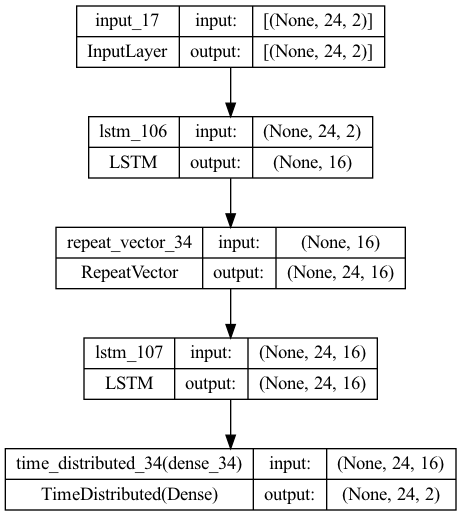

In [267]:
dot_img_file = '/Users/kirsh012/Downloads/model_blargh.png'
tf.keras.utils.plot_model(autoencoder.build_graph(), to_file=dot_img_file, show_shapes=True)

<AxesSubplot:title={'center':'LSTM Autoencoder'}, xlabel='Epochs', ylabel='Loss'>

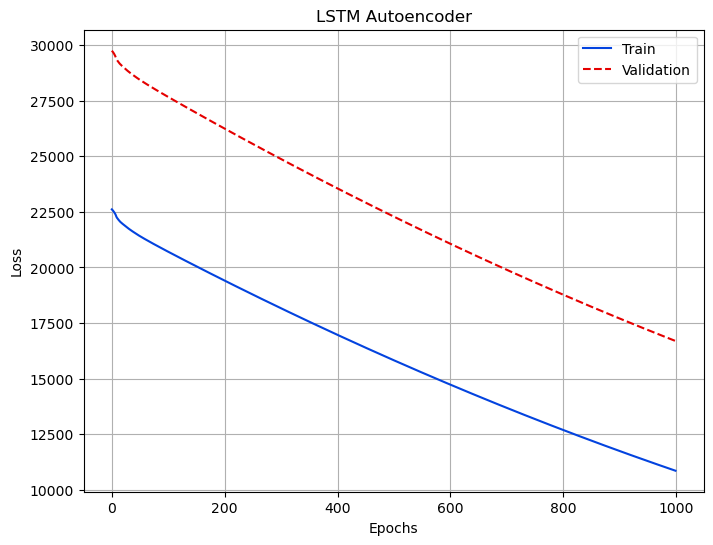

In [268]:
# Plot Train and Val loss
viz.plot_loss(history.history['loss'], history.history['val_loss'], title = 'LSTM Autoencoder')

In [269]:
# A = np.array([[1,2], [1,2], [1,2]])
# B = np.array([[1,1], [0,0], [1,2]])
# for row in range(A.shape[0]):
#     print(mean_absolute_error(A[row,:], B[row,:]))

In [270]:
### Test the MAE and R^2 of the train, val and test datasets for the autoencoder
train_reconstructions = autoencoder.predict(train_data, BATCH_SIZE)
val_reconstructions   = autoencoder.predict(val_data, BATCH_SIZE)
test_reconstructions  = autoencoder.predict(test_data, BATCH_SIZE)

108/108 [==============================] - 1s 10ms/step


In [271]:
# # Calculate the mean MAE and R^2 for each dataset
# train_mae_list = []
# train_r2_list  = []
# for tri in range(train_data.shape[0]):
#     train_mae = mean_absolute_error(train_data[tri], train_reconstructions[tri,:,:])
#     train_r2  = r2_score(train_data[tri], train_reconstructions[tri,:,:])
    
#     train_mae_list.append(train_mae)
#     train_r2_list.append(train_r2)
    
# test_mae_list  = []
# test_r2_list   = []
# for tei in range(test_data.shape[0]):
#     test_mae = mean_absolute_error(test_data[tei], test_reconstructions[tei,:,:])
#     test_r2  = r2_score(test_data[tei], test_reconstructions[tei,:,:])
    
#     test_mae_list.append(test_mae)
#     test_r2_list.append(test_r2)

# val_mae_list   = []
# val_r2_list    = []
# for vi in range(val_data.shape[0]):
#     val_mae = mean_absolute_error(val_data[vi], val_reconstructions[vi,:,:])
#     val_r2  = r2_score(val_data[vi], val_reconstructions[vi,:,:])
    
#     val_mae_list.append(val_mae)
#     val_r2_list.append(val_r2)

In [272]:
# # Print the Mean MAE and R^2
# print("Train MAE: ", np.mean(train_mae_list))
# print("Test MAE: ", np.mean(test_mae_list))
# print("Val MAE: ", np.mean(val_mae_list))

# print("Train R-squared: ", np.mean(train_r2_list))
# print("Test R-squared: ", np.mean(test_r2_list))
# print("Val R-squared: ", np.mean(val_r2_list))

In [273]:
### Plot the traces for Train, Test, Val ###
import matplotlib.pyplot as plt
import seaborn as sns

def legend_without_duplicate_labels(ax):
    '''https://stackoverflow.com/questions/19385639/duplicate-items-in-legend-in-matplotlib'''
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))
    
def plot_traces(real_data, reconstructions, dataset='Train'):
    
    fig, ax = plt.subplots()

    pdx = np.random.choice(range(real_data.shape[0]), size = 1)

    ax.plot(real_data[pdx, :, 0].T, label = f'{dataset} True - Left', linestyle='-', color = 'xkcd:orange')
    ax.plot(real_data[pdx, :, 1].T, label = f'{dataset} True - Right', linestyle='-', color = 'xkcd:red')

    ax.plot(reconstructions[pdx, :, 0].T, label = f'{dataset} Predictions - Left', linestyle='--', color = 'xkcd:blue')
    ax.plot(reconstructions[pdx, :, 1].T, label = f'{dataset} Predictions - Right', linestyle='--', color = 'xkcd:black')
    
    ax.set_title(f'{dataset} Traces')
    ax.set_xlabel('Time Points')
    ax.set_ylabel('Glucose')
    
    legend_without_duplicate_labels(ax)
    return ax

<AxesSubplot:title={'center':'Val Traces'}, xlabel='Time Points', ylabel='Glucose'>

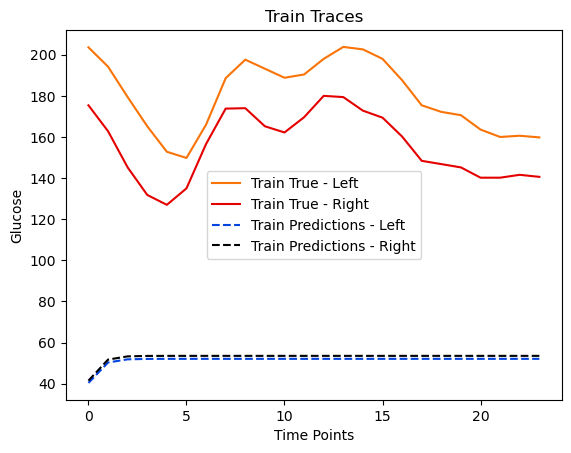

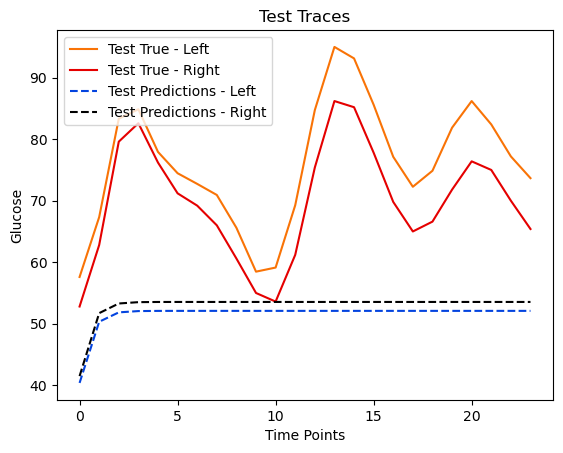

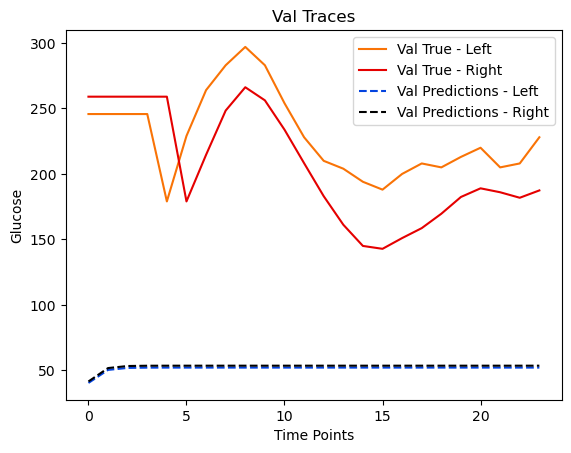

In [274]:
# Train #
plot_traces(train_data, train_reconstructions)

# Test #
plot_traces(test_data, test_reconstructions, 'Test')

# Validation #
plot_traces(val_data, val_reconstructions, 'Val')

In [230]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [231]:
# reshape into X=t and Y=t+1
train = np.random.randn(100, 1)
look_back = 24
trainX, trainY = create_dataset(train, look_back)

In [238]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
print(trainX.shape)

(75, 1, 24)


In [240]:
trainY.shape

(75,)

In [239]:
new_train = np.reshape(train_data, (train_data.shape[0], train_data.shape[2], train_data.shape[1]))
new_train.shape

(2345, 2, 24)

In [250]:
r2_score(train_data[100], train_reconstructions[100,:,:])

-239.3709311085329

In [251]:
class ThresholdEstimator:

    def __init__(self) -> None:
        self.mu        = 0
        self.sigma     = 1
        self.threshold = None

    def _get_likelihoods(self, errors):
        print(errors.shape)
        
        n = errors.shape[0]
        l = -n/2*np.log(2*np.pi) - (n/2)*np.log(self.sigma**2) - (1/(2*self.sigma**2))*(errors - self.mu)**2
        return l
    
    def fit(self, model, data, target, batch_size):

        # Reconstruct the data
        reconstructions = model.predict(data, batch_size)
        print("Reconstructions:")
        print(reconstructions.shape)
        print(reconstructions[:5].shape)
        print(reconstructions[:5, :5].shape)
        print(reconstructions[:5, :, :])
        
        print("Data:")
        print(data.shape)
        print(data[:5].shape)
        print(data[:5, :5].shape)
        print(data[:5, :, :])
        errors = tf.keras.losses.mse(self._compress_array(reconstructions), self._compress_array(data))
        
        # Estimate the normal distribution of the errors
        self.mu    = np.mean(errors, axis = 0)
        self.sigma = np.cov(errors)

        #likelihoods = multivariate_normal.pdf(errors, mean=self.mu, cov=self.sigma)
        #likelihoods  = norm.pdf(errors, loc=self.mu, scale=self.sigma)
        #likelihoods = self._get_likelihoods(errors)
        likelihoods = norm.logpdf(errors, loc=self.mu, scale=self.sigma)
        print("Likelihoods:")
        print(likelihoods)

        f_list = []
        
        thresholds = np.linspace(min(likelihoods), max(likelihoods), 100)
        
        for t in thresholds:

            preds = (likelihoods<t).astype(int)
            f = fbeta_score(target, preds, beta=0.1, zero_division=0)
            f_list.append(f)

        bidx = np.argmax(f_list)
        
        self.best_threshold = np.max(errors)
        #self.best_threshold = np.quantile(errors, 0.95) #thresholds[bidx]

        return self
    
    def _compress_array(self, array):
        compressed_array = [array[sample, array.shape[1]-1, :] for sample in range(array.shape[0])]
    
        return compressed_array
    
    def predict(self, model, data, target, batch_size):
        
        reconstructions = model.predict(data, batch_size)
        errors = np.array(tf.keras.losses.mse(self._compress_array(reconstructions), self._compress_array(data)))
        print(errors[:5])
#         #likelihoods = multivariate_normal.pdf(errors, mean=self.mu, cov=self.sigma)
#         #likelihoods = norm.pdf(errors, loc=self.mu, scale=self.sigma)
#         likelihoods = np.array(errors)
#         print(likelihoods[:5])
#        pred_labels = (likelihoods < self.best_threshold).astype(int)
        likelihoods = errors
        pred_labels = (errors > self.best_threshold).astype(int)
        return likelihoods, pred_labels

In [252]:
# Get the reconstructions and the error
train_reconstructions = autoencoder.predict(train_data, BATCH_SIZE)

74/74 [==============================] - 0s 2ms/step


In [253]:
train_reconstructions

array([[[ 99.01585 , 106.6728  ,  99.27241 , ..., 110.48065 ,
         102.6205  , 110.68894 ],
        [107.433014, 115.48764 , 107.87345 , ..., 119.40853 ,
         111.582825, 119.83797 ]],

       [[ 98.50775 , 106.12483 ,  98.763176, ..., 109.9116  ,
         102.09573 , 110.120995],
        [106.854935, 114.8509  , 107.30388 , ..., 118.75242 ,
         110.99215 , 119.18501 ]],

       [[ 98.50775 , 106.12483 ,  98.763176, ..., 109.9116  ,
         102.09573 , 110.120995],
        [106.854935, 114.8509  , 107.30388 , ..., 118.75242 ,
         110.99215 , 119.18501 ]],

       ...,

       [[ 98.5078  , 106.1249  ,  98.76323 , ..., 109.91168 ,
         102.0958  , 110.12106 ],
        [106.854996, 114.85098 , 107.30393 , ..., 118.7525  ,
         110.9922  , 119.185074]],

       [[ 98.50775 , 106.12483 ,  98.763176, ..., 109.9116  ,
         102.09573 , 110.120995],
        [106.854935, 114.8509  , 107.30388 , ..., 118.75242 ,
         110.99215 , 119.18501 ]],

       [[ 98.5077

In [254]:
# Fit the threshold using the validation dataset.
ter = ThresholdEstimator()

ter.fit(autoencoder, val_data, y_val, BATCH_SIZE)

56/56 [==============================] - 0s 2ms/step
Reconstructions:
(1783, 2, 24)
(5, 2, 24)
(5, 2, 24)
[[[ 98.50775  106.12483   98.763176 106.38549   99.22171  106.65162
    99.606544 107.19965  100.02988  107.514366 100.167786 107.91793
   100.64234  108.136    101.12937  108.6566   101.293686 108.97436
   101.60615  109.52081  101.9405   109.9116   102.09573  110.120995]
  [106.854935 114.85091  107.30388  115.25397  107.560646 115.74623
   107.889755 115.97508  108.22664  116.47119  108.832344 116.87114
   109.10416  117.504295 109.38581  117.78952  109.91957  118.263374
   110.290016 118.484665 110.58353  118.75242  110.99215  119.18501 ]]

 [[ 98.50775  106.12483   98.763176 106.38549   99.22171  106.65162
    99.606544 107.19965  100.02988  107.514366 100.167786 107.91793
   100.64234  108.136    101.12937  108.6566   101.293686 108.97436
   101.60615  109.52081  101.9405   109.9116   102.09573  110.120995]
  [106.854935 114.8509   107.30388  115.25397  107.56064  115.74623
 

In [255]:
test_preds, test_labels = ter.predict(autoencoder, data[val_idx], target[val_idx], BATCH_SIZE)

fpr_test, tpr_test, thresh_test  = roc_curve(target[val_idx], test_preds)
ppr_test, rec_test, pthresh_test = precision_recall_curve(target[val_idx], test_preds)

print("Test AU-ROC: ", auc(fpr_test, tpr_test))
print("Test AU-PRC: ", auc(rec_test, ppr_test))
print("F-0.1 Score: ", fbeta_score(target[val_idx], test_labels, beta=0.1))

InvalidArgumentError: Graph execution error:

Detected at node 'while/MatMul' defined at (most recent call last):
    File "/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/vf/3xw3wws956q2sqm5zx7w2n800000gp/T/ipykernel_5238/3729895500.py", line 1, in <cell line: 1>
      test_preds, test_labels = ter.predict(autoencoder, data[val_idx], target[val_idx], BATCH_SIZE)
    File "/var/folders/vf/3xw3wws956q2sqm5zx7w2n800000gp/T/ipykernel_5238/289516813.py", line 67, in predict
      reconstructions = model.predict(data, batch_size)
    File "/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/site-packages/keras/engine/training.py", line 2033, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/site-packages/keras/engine/training.py", line 1845, in predict_function
      return step_function(self, iterator)
    File "/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/site-packages/keras/engine/training.py", line 1834, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/site-packages/keras/engine/training.py", line 1823, in run_step
      outputs = model.predict_step(data)
    File "/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/site-packages/keras/engine/training.py", line 1791, in predict_step
      return self(x, training=False)
    File "/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/var/folders/vf/3xw3wws956q2sqm5zx7w2n800000gp/T/ipykernel_5238/3199113141.py", line 18, in call
      x = self.lstm1(x)
    File "/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/site-packages/keras/layers/rnn/base_rnn.py", line 515, in __call__
      return super(RNN, self).__call__(inputs, **kwargs)
    File "/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/site-packages/keras/layers/rnn/lstm.py", line 673, in call
      runtime) = lstm_with_backend_selection(**normal_lstm_kwargs)
    File "/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/site-packages/keras/layers/rnn/lstm.py", line 1183, in lstm_with_backend_selection
      last_output, outputs, new_h, new_c, runtime = defun_standard_lstm(**params)
    File "/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/site-packages/keras/layers/rnn/lstm.py", line 891, in standard_lstm
      last_output, outputs, new_states = backend.rnn(
    File "/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/site-packages/keras/backend.py", line 4776, in rnn
      final_outputs = tf.compat.v1.while_loop(
    File "/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/site-packages/keras/backend.py", line 4759, in _step
      output, new_states = step_function(current_input,
    File "/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/site-packages/keras/layers/rnn/lstm.py", line 877, in step
      z = backend.dot(cell_inputs, kernel)
    File "/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/site-packages/keras/backend.py", line 2223, in dot
      out = tf.matmul(x, y)
Node: 'while/MatMul'
Matrix size-incompatible: In[0]: [32,2], In[1]: [24,96]
	 [[{{node while/MatMul}}]]
	 [[functional_lstm_auto_encoder_5/lstm_10/PartitionedCall]] [Op:__inference_predict_function_348463]

In [123]:
### Try a convolutional model
conv_model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(train_data.shape[1], train_data.shape[2])),
        tf.keras.layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        tf.keras.layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        tf.keras.layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
        
        tf.keras.layers.TimeDistributed(
            tf.keras.layers.Dense(2, activation = 'relu'))
    ]
)
conv_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse")

In [ ]:
conv_history = conv_model.fit(
    train_data,
    train_data,
    epochs=50,
    batch_size=16,
    validation_split=0.1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)


In [ ]:
# Plot Train and Val loss
viz.plot_loss(conv_history.history['loss'], conv_history.history['val_loss'], title = 'Convolutional Autoencoder')

In [ ]:
tcr = ThresholdEstimator()

tcr.fit(conv_model, val_data, y_val)

ctest_preds, ctest_labels = tcr.predict(conv_model, test_data, y_test)

cfpr_test, ctpr_test, cthresh_test = roc_curve(y_test, ctest_preds)
cppr_test, crec_test, cpthresh_test = precision_recall_curve(y_test, ctest_preds)

print("Test AU-ROC: ", auc(cfpr_test, ctpr_test))
print("Test AU-PRC: ", auc(crec_test, cppr_test))
print("F-0.1 Score: ", fbeta_score(y_test, ctest_labels, beta=1))

In [ ]:
# def get_optimal_threshold(errors, target):

#     # Estimate the normal distribution of the errors
#     mu_vector  = np.mean(errors, axis = 0)
#     cov_matrix = np.cov(errors)

#     likelihoods = norm.pdf(errors, loc=mu_vector, scale=cov_matrix) * errors
#     print(likelihoods[:5])
#     f_list = []
#     thresholds = np.arange(min(likelihoods), max(likelihoods), 0.001)
#     print(thresholds)
#     for t in thresholds:

#         preds = (likelihoods<t).astype(int)
#         f = fbeta_score(target, preds, beta=0.1)
#         f_list.append(f)

#     best_threshold = np.argmax(f_list)

#     return likelihoods, thresholds[best_threshold]

def compress_array(array):
     compressed_array = [array[sample, array.shape[1]-1, :] for sample in range(array.shape[0])]
    
     return compressed_array

# def reconstruct(model, data, target, threshold=None):
#     reconstructions = model.predict(data)
#     errors = tf.keras.losses.mae(compress_array(reconstructions), compress_array(data))

#     if threshold is None:
#         errors, threshold = get_optimal_threshold(errors, target)
# # 
#     #preds = predict_scores(model, data, threshold)

#     return errors, threshold

### Reconstruction Comparison

In [ ]:
reconstructions = conv_model.predict(train_data)
errors = tf.keras.losses.mae(compress_array(reconstructions), compress_array(train_data))

In [ ]:
sns.histplot(errors)

In [ ]:
val_reconstructions = conv_model.predict(val_data)
val_errors = tf.keras.losses.mae(compress_array(val_reconstructions), compress_array(val_data))

In [ ]:
np.unique(test_labels)

In [ ]:
from scipy.stats import norm

norm.pdf(errors, loc=mu_vector, scale = cov_matrix)

In [ ]:
multivariate_normal.pdf(errors, mean=mu_vector, cov=cov_matrix)

In [ ]:
sns.histplot(val_errors)

In [ ]:
atrain_reconstructions = conv_model.predict(anomalous_train)
atrain_errors = tf.keras.losses.mae(compress_array(atrain_reconstructions), compress_array(anomalous_train))

In [ ]:
sns.histplot(atrain_errors)

In [ ]:
aval_reconstructions = conv_model.predict(anomalous_val)
aval_errors = tf.keras.losses.mae(compress_array(aval_reconstructions), compress_array(anomalous_val))

sns.histplot(aval_errors)

In [ ]:
### See the reconstruction loss on the Training Dataset
train_scores, threshold = reconstruct(autoencoder, train_data, y_train, threshold=None)

In [ ]:
threshold

In [ ]:
len(train_scores)

In [ ]:
sum(train_scores> threshold)

In [ ]:
val_scores, _ = reconstruct(autoencoder, val_data, y_val, threshold = threshold)

In [ ]:
val_scores

In [ ]:
### Run hypertuning
tuner = kt.Hyperband(model,
                        objective='val_loss',
                        max_epochs=100,
                        factor=3,
                        overwrite=True,
                        directory='test-3-jk',
                        project_name='lstm-autoencoder')

# Run the hypertuning search
tuner.search(train_data, train_data, epochs=50, validation_data = (val_data, val_data), batch_size=512,
            callbacks=[early_stopping], class_weight=train_weights)

In [ ]:
### Test loading data for 